# imports

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.max_columns", None)

In [3]:
csv_path = Path(r"C:\Users\user\Desktop\div\data\files\housing.csv")
df = pd.read_csv(csv_path)
df.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


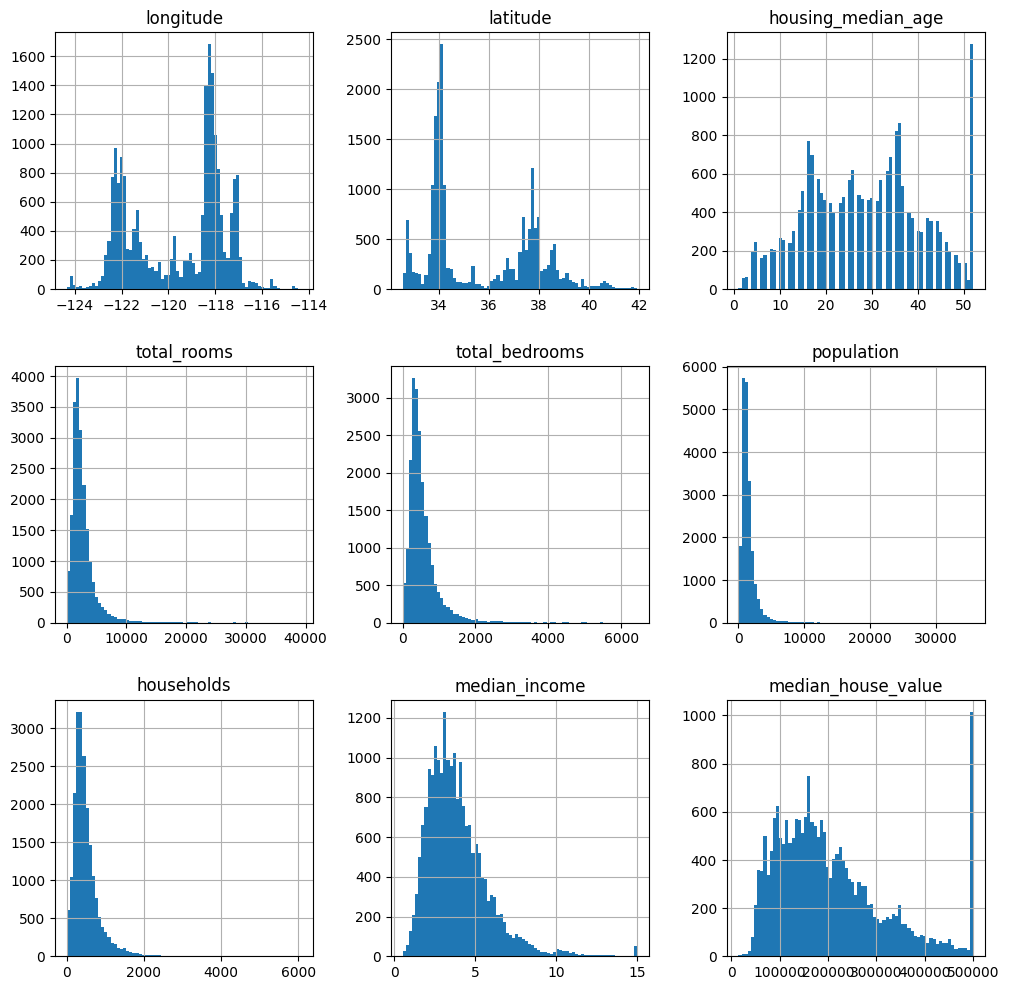

In [4]:
df.select_dtypes(include=['number']).hist(bins=75, figsize=(12, 12))
plt.show()

# outliers

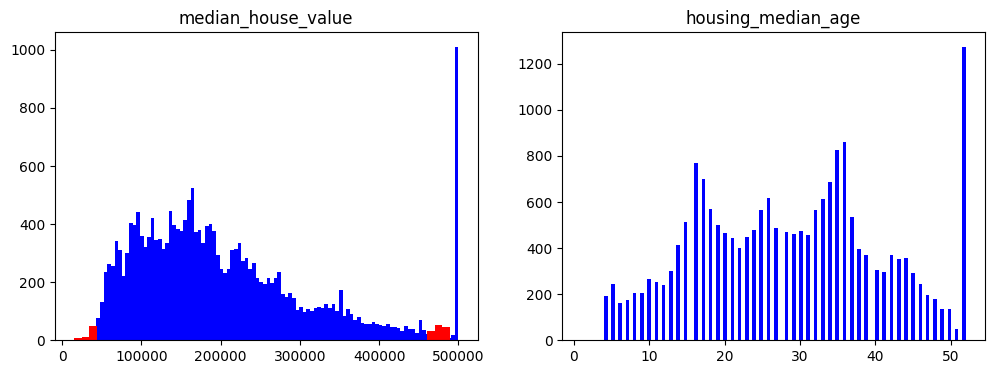

In [5]:
from sklearn.ensemble import IsolationForest
iso_f = IsolationForest(contamination=0.01)
pred_iso1 = iso_f.fit_predict(df[['median_house_value']])
pred_iso2 = iso_f.fit_predict(df[['housing_median_age']])
outliers1 = pred_iso1 == -1
outliers2 = pred_iso2 == -1
outliers = outliers1 | outliers2

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(df.loc[~outliers1, 'median_house_value'], bins=100, color='blue')
axs[0].hist(df.loc[outliers1, 'median_house_value'], bins=50, color='red')
axs[1].hist(df.loc[~outliers2, 'housing_median_age'], bins=100, color='blue')
axs[1].hist(df.loc[outliers2, 'housing_median_age'], bins=100, color='red')
axs[0].set_title('median_house_value')
axs[1].set_title('housing_median_age')
plt.show()

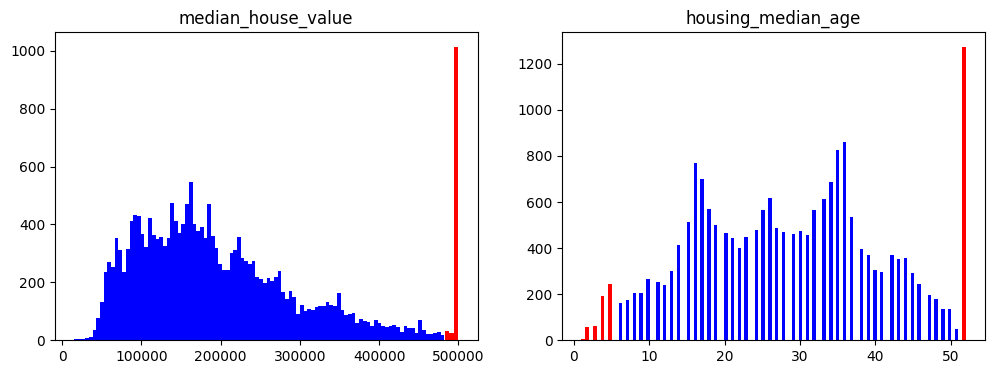

In [6]:
def find_outliers_with_median(series):
    q1,q3 = series.quantile([0.25, 0.75])
    iqr = np.abs(q3 - q1)

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outlier_mask = (series < lower_bound) | (series > upper_bound)
    return outlier_mask

def find_outliers_with_mean(series, threshold=3):
    mean = series.mean()
    std = series.std()

    lower_bound = mean - threshold * std
    upper_bound = mean + threshold * std

    outlier_mask = (series < lower_bound) | (series > upper_bound)
    return outlier_mask

outliers1 = find_outliers_with_median(df['median_house_value'])
outliers2 = find_outliers_with_mean(df['housing_median_age'], threshold=1.8)
outliers = outliers1 | outliers2

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(df.loc[~outliers1, 'median_house_value'], bins=100, color='blue')
axs[0].hist(df.loc[outliers1, 'median_house_value'], bins=3, color='red')
axs[1].hist(df.loc[~outliers2, 'housing_median_age'], bins=100, color='blue')
axs[1].hist(df.loc[outliers2, 'housing_median_age'], bins=100, color='red')
axs[0].set_title('median_house_value')
axs[1].set_title('housing_median_age')
plt.show()

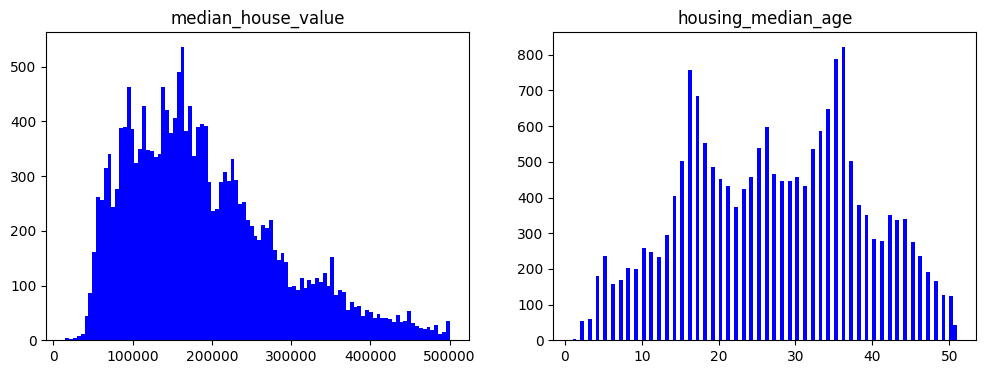

In [7]:
outliers1 = df['median_house_value'] == df['median_house_value'].max()
outliers2 = df['housing_median_age'] == df['housing_median_age'].max()
outliers = outliers1 | outliers2

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(df.loc[~outliers, 'median_house_value'], bins=100, color='blue')
axs[1].hist(df.loc[~outliers, 'housing_median_age'], bins=100, color='blue')
axs[0].set_title('median_house_value')
axs[1].set_title('housing_median_age')
plt.show()


In [8]:
df = df.loc[~outliers, :].copy()
print(df.shape)
df.head(3)

(18572, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY


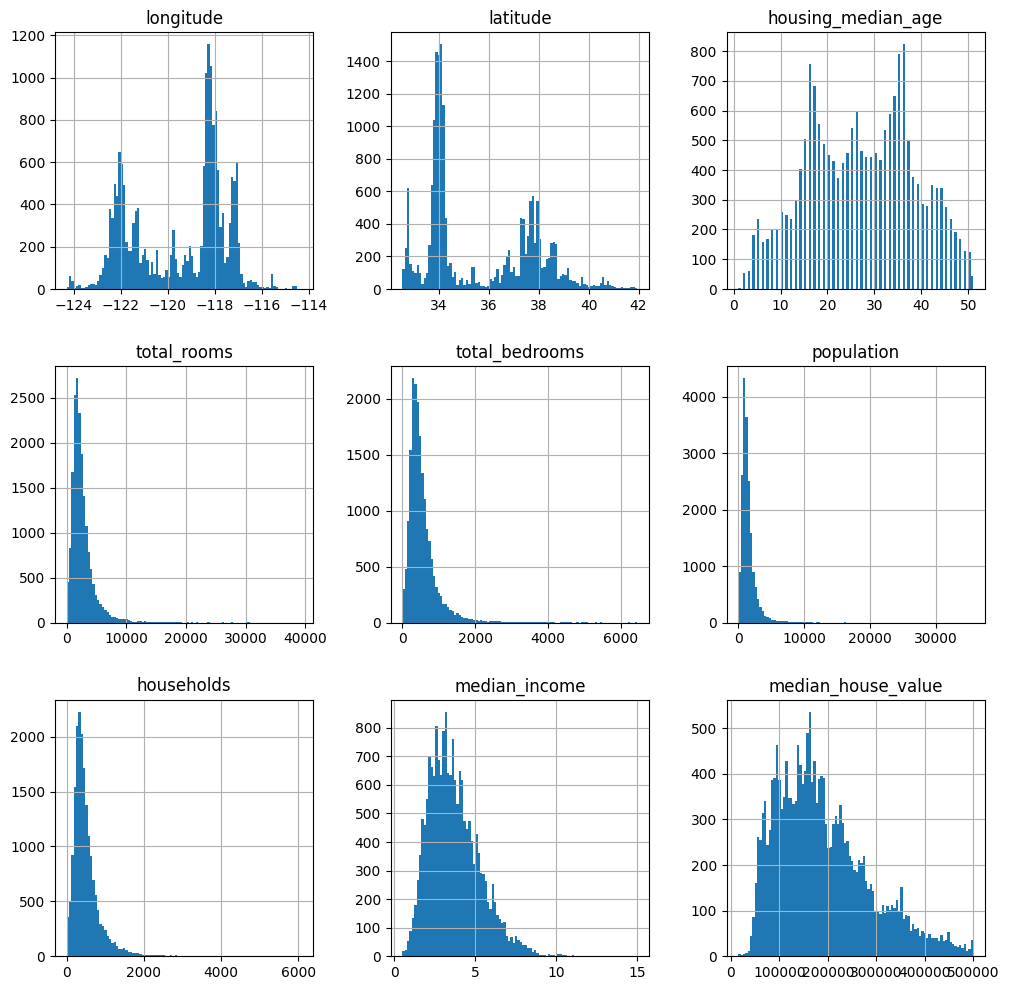

In [9]:
df.select_dtypes(include=['number']).hist(bins=100, figsize=(12, 12))
plt.show()

# split

In [10]:
X = df.drop('median_house_value', axis='columns')
y = df['median_house_value']

In [11]:
X['income_cat'] = pd.cut(
    X['median_income'],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
    )

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=X['income_cat'],
    test_size=0.2
    )

X_train.shape, X_test.shape

((14857, 10), (3715, 10))

In [13]:
X_train.drop('income_cat', axis='columns', inplace=True)
X_test.drop('income_cat', axis='columns', inplace=True)

# pipeline

In [14]:
import plotly.express as px

fig = px.scatter_map(
    df, 
    lat="latitude",
    lon="longitude",
    size="population",
    zoom=4,
)

fig.show()

In [15]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans

n_clusters = 10
kmeans_ = KMeans(n_clusters = n_clusters)
kmeans_.fit(X_train[['latitude', 'longitude']])
print(kmeans_.cluster_centers_)

[[  34.87393602 -119.6289847 ]
 [  32.91226891 -117.11878533]
 [  38.65989293 -122.71550321]
 [  37.74530612 -122.17727891]
 [  38.82798561 -121.20396483]
 [  36.6172     -119.6032375 ]
 [  34.00421502 -118.06697233]
 [  40.72662252 -122.93175497]
 [  37.37518072 -121.4611747 ]
 [  33.60862416 -116.07412752]]


In [17]:
import plotly.express as px
import plotly.graph_objects as go

df_centroids = pd.DataFrame(kmeans_.cluster_centers_, columns=["latitude", "longitude"])

fig = px.scatter_map(
    df,
    lat="latitude",
    lon="longitude",
    opacity=0.5,
    zoom=4
)
fig.add_trace(go.Scattermap(
    lat=df_centroids["latitude"],
    lon=df_centroids["longitude"],
    mode='markers',
    marker=go.scattermap.Marker(size=12, color='red', opacity=0.7),
))

fig.show()

In [18]:
rbf_kernel(X_train[['latitude', 'longitude']], kmeans_.cluster_centers_, gamma=1).round(2)

array([[0.  , 0.28, 0.  , ..., 0.  , 0.  , 0.11],
       [0.  , 0.  , 0.14, ..., 0.  , 0.21, 0.  ],
       [0.  , 0.3 , 0.  , ..., 0.  , 0.  , 0.68],
       ...,
       [0.  , 0.  , 0.07, ..., 0.  , 0.88, 0.  ],
       [0.02, 0.22, 0.  , ..., 0.  , 0.  , 0.04],
       [0.  , 0.  , 0.02, ..., 0.  , 0.83, 0.  ]], shape=(14857, 10))

In [19]:
#  K(x, y) = exp(-gamma ||x-y||^2)
x = X_train.iloc[0, [1,0]].to_numpy()
y = np.array(kmeans_.cluster_centers_)

np.exp(-1 * (np.linalg.norm(x-y, axis=1)**2)).round(2)

array([0.  , 0.28, 0.  , 0.  , 0.  , 0.  , 0.73, 0.  , 0.  , 0.11])

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10):
        self.n_clusters = n_clusters

    def fit(self, X):
        self.kmeans_ = KMeans(self.n_clusters)
        self.kmeans_.fit(X)
        return self  

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=1).round(3)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [24]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

cat_cols = ['ocean_proximity']
log_cols = [
    'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'
    ]

cat_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])
log_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(np.log1p, inverse_func=np.expm1, feature_names_out='one-to-one')),
    ('scl', StandardScaler())
])
new_col_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('newcol', FunctionTransformer(lambda x: x[:, [0]] / x[:, [1]], feature_names_out=lambda *args, **kw_args: ['ratio'])),
    ('scl', StandardScaler())
])
cluster_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('cluster', ClusterSimilarity(n_clusters=10))
])
num_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('scl', StandardScaler())
])

preprocessing = ColumnTransformer(
    transformers=[
        ('CAT', cat_pipeline, cat_cols),
        ('LOG', log_pipeline, log_cols),
        ('NEWC_b/r', new_col_pipeline, ['total_bedrooms', 'total_rooms']),
        ('NEWC_r/h', new_col_pipeline, ['total_rooms', 'households']),
        ('NEWC_p/h', new_col_pipeline, ['population', 'households']),
        ("GEO", cluster_pipeline, ["latitude", "longitude"]),
    ], remainder=num_pipeline
)

X_train_arr = preprocessing.fit_transform(X_train)
X_train_prepared = pd.DataFrame(X_train_arr, columns=preprocessing.get_feature_names_out())

X_test_arr = preprocessing.fit_transform(X_test)
X_test_prepared = pd.DataFrame(X_test_arr, columns=preprocessing.get_feature_names_out())

X_train_prepared

,CAT__ocean_proximity_<1H OCEAN,CAT__ocean_proximity_INLAND,CAT__ocean_proximity_ISLAND,CAT__ocean_proximity_NEAR BAY,CAT__ocean_proximity_NEAR OCEAN,LOG__total_rooms,LOG__total_bedrooms,LOG__population,LOG__households,LOG__median_income,NEWC_b/r__ratio,NEWC_r/h__ratio,NEWC_p/h__ratio,GEO__Cluster 0 similarity,GEO__Cluster 1 similarity,GEO__Cluster 2 similarity,GEO__Cluster 3 similarity,GEO__Cluster 4 similarity,GEO__Cluster 5 similarity,GEO__Cluster 6 similarity,GEO__Cluster 7 similarity,GEO__Cluster 8 similarity,GEO__Cluster 9 similarity,remainder__housing_median_age
0,0.0,1.0,0.0,0.0,0.0,-2.405092,-2.711359,-2.531742,-2.709668,0.146399,-0.633791,0.380962,0.006991,0.000,0.641,0.000,0.233,0.000,0.000,0.000,0.043,0.000,0.973,0.701443
1,0.0,1.0,0.0,0.0,0.0,-1.005859,-1.476744,-1.791538,-1.296398,1.637086,-1.025830,0.411210,-0.095797,0.431,0.000,0.004,0.000,0.000,0.205,0.001,0.000,0.911,0.000,-0.875331
2,0.0,1.0,0.0,0.0,0.0,-0.411328,-0.248757,-0.889632,-0.572811,-1.725323,0.353367,0.176702,-0.071878,0.000,0.091,0.000,0.342,0.000,0.000,0.000,0.001,0.000,0.587,-0.437338
3,0.0,1.0,0.0,0.0,0.0,-0.564542,-0.299595,-0.577096,-0.322338,-1.029090,0.663297,-0.519494,-0.062750,0.395,0.000,0.007,0.000,0.000,0.294,0.001,0.000,0.842,0.000,1.489830
4,1.0,0.0,0.0,0.0,0.0,0.274833,0.348756,0.178431,0.402889,0.844878,0.054658,-0.307799,-0.057082,0.000,0.938,0.000,0.034,0.003,0.000,0.000,0.366,0.000,0.311,1.314633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14852,0.0,0.0,0.0,0.0,1.0,1.289642,1.419617,1.097627,1.387413,0.808278,0.107125,-0.210120,-0.064799,0.184,0.000,0.000,0.000,0.000,0.963,0.000,0.000,0.053,0.000,-1.050528
14853,0.0,1.0,0.0,0.0,0.0,1.035169,0.952621,0.817038,0.955558,-0.363326,-0.383623,0.095263,-0.042883,0.300,0.000,0.006,0.000,0.000,0.102,0.001,0.000,0.986,0.000,-1.050528
14854,1.0,0.0,0.0,0.0,0.0,0.247058,0.502954,1.119181,0.596873,-0.222934,0.553982,-0.640644,0.090393,0.423,0.000,0.000,0.000,0.002,0.787,0.004,0.000,0.058,0.000,-1.488521
14855,1.0,0.0,0.0,0.0,0.0,0.154375,0.592158,0.233173,0.415679,-0.073722,1.130230,-0.518434,-0.050750,0.000,0.902,0.000,0.161,0.000,0.000,0.000,0.106,0.000,0.751,-0.437338
